# Correlations among time series

This notebook examines the correlation between time series.

In [1]:
import sys
sys.path.append('../TimeSeries/')

import time_series as ts
import numpy as np
import matplotlib.pyplot as plt

Load a few ENTSO-E models:

In [2]:
CH_model = ts.import_model('../TimeSeries/models/entsoe_load_CH_2015_2023.npz')
DE_model = ts.import_model('../TimeSeries/models/entsoe_load_DE_2015_2023.npz')
FR_model = ts.import_model('../TimeSeries/models/entsoe_load_FR_2015_2023.npz')

## Definitions

Suppose that we have $N$ time series with $T$ time steps each, which we denote by $f_t^n$ with $t = 1, \ldots, T$ and $n = 1, \ldots, N$.

We also denote with $g_u^n$ the Fourier transform of each of the $N$ series with respect to time. There are also $T$ real components in each Fourier series ($u = 1, \ldots, T$).
Since this is a linear transformation, there exists an $T \times T$ matrix $A$ such that
$$f_t^n = \sum_{u=1}^T A_{t,u} g_u^n$$

The $g_u^n$ follow a multivariate normal distribution with mean
$$\mu_u = \frac{1}{N} \sum_{n = 1}^N g_u^n$$
and covariance
$$\sigma_{uv} = \frac{1}{N} \sum_{n = 1}^N (g_u^n - \mu_u) (g_v^n - \mu_v)  = \frac{1}{N} \sum_{n = 1}^N g_u^n g_v^n - \mu_u \mu_v$$
$\mu$ and $\sigma$ are fixed by the model.

Here we create a sample with $N = 1000$:

In [3]:
CH_series = ts.generate_time_series(CH_model, 1000)
DE_series = ts.generate_time_series(DE_model, 1000)
FR_series = ts.generate_time_series(FR_model, 1000)

## Average characteristics of the time series

Let us denote with $\langle \cdot \rangle$ the average over $N$ series:
$$\langle f_t \rangle = \frac{1}{N} \sum_{n=1}^N f_t^n$$

This is equal to the Fourier transform of $\mu$:
$$\langle f_t \rangle = \frac{1}{N} \sum_{n=1}^N \sum_{u=1}^T A_{t,u} g_u^n = \sum_{u=1}^T A_{t,u} \mu_u$$

In [4]:
CH_mean_series = ts.get_mean(CH_model)
DE_mean_series = ts.get_mean(DE_model)
FR_mean_series = ts.get_mean(FR_model)

With $N = 1000$, the difference between the statistical average and the model is below the percent level:

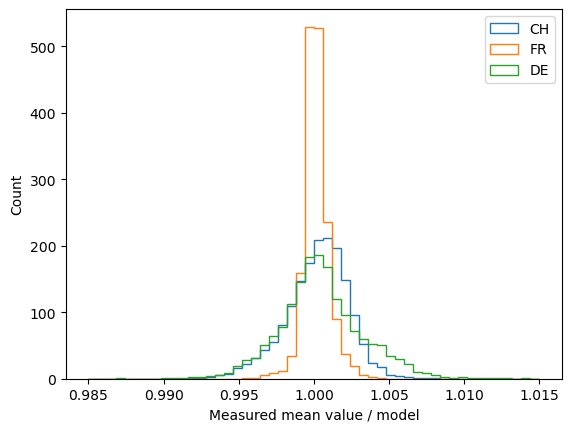

In [5]:
plt.hist(CH_series.mean(axis = 0) / CH_mean_series,
         range=(0.985, 1.015), bins=50, histtype='step', density=True, label='CH')
plt.hist(DE_series.mean(axis = 0) / DE_mean_series, 
         range=(0.985, 1.015), bins=50, histtype='step', density=True, label='FR')
plt.hist(FR_series.mean(axis = 0) / FR_mean_series, 
         range=(0.985, 1.015), bins=50, histtype='step', density=True, label='DE')
plt.legend()
plt.xlabel('Measured mean value / model')
plt.ylabel('Count')
plt.show()

Similarly, we can define the covariance of the time series as:
$$
\text{cov}_N(f_t, f_{t'}) = \langle f_t f_{t'} \rangle - \langle f_t \rangle \langle f_{t'} \rangle
= \frac{1}{N} \sum_{n=1}^N f_t^n f_{t'}^n - \frac{1}{N^2} \sum_{n = 1}^N f_t^n \sum_{n' = 1}^N f_{t'}^{n'}
$$

This is equal to the Fourier transform of $\sigma$,
$$
\text{cov}_N(f_t, f_{t'}) = \sum_{u=1}^T \sum_{v=1}^T A_{t,u} A_{t', v} \sigma_{uv}
$$

Because of the simplification that takes place in the model (Fourier modes below a certain threshold are discarded), the measured covariance can differ a bit from the model's prediction:

In [6]:
CH_cov_N = ts.get_covariance_matrix(CH_model)
FR_cov_N = ts.get_covariance_matrix(FR_model)

In [7]:
CH_cov_N_measured = np.cov(CH_series, rowvar=False, bias=True)
FR_cov_N_measured = np.cov(FR_series, rowvar=False, bias=True)

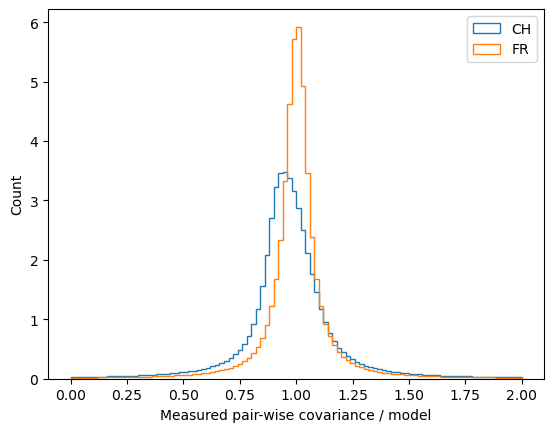

In [8]:
CH_cov_N_ratio = CH_cov_N_measured / CH_cov_N
FR_cov_N_ratio = FR_cov_N_measured / FR_cov_N

plt.hist(CH_cov_N_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='CH')
plt.hist(FR_cov_N_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='FR')
plt.xlabel('Measured pair-wise covariance / model')
plt.ylabel('Count')
plt.legend()
plt.show()

However, the mean value is quite accurate:

In [9]:
CH_cov_N_measured.mean() / CH_cov_N.mean(), FR_cov_N_measured.mean() / FR_cov_N.mean()

(0.942705435397427, 1.0072365891294683)

The accuracy is better when considering only the variance (the diagonal of the covariance matrix):

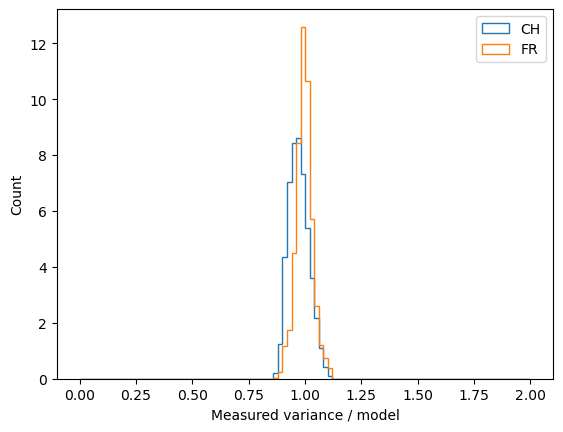

In [10]:
CH_var_N_ratio = CH_cov_N_measured.diagonal() / CH_cov_N.diagonal()
FR_var_N_ratio = FR_cov_N_measured.diagonal() / FR_cov_N.diagonal()

plt.hist(CH_var_N_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='CH')
plt.hist(FR_var_N_ratio.flatten(), range=(0, 2), bins=100, histtype='step', density=True, label='FR')
plt.xlabel('Measured variance / model')
plt.ylabel('Count')
plt.legend()
plt.show()

In [11]:
CH_cov_N_measured.diagonal().mean() / CH_cov_N.diagonal().mean()

0.9694406494783753

In [12]:
FR_cov_N_measured.diagonal().mean() / FR_cov_N.diagonal().mean()

0.9945566727821404

## Covariance between time series

Denote with a bar the average over $T$ time steps:
$$\bar{f}^n = \frac{1}{T} \sum_{t=1}^T f_t^n$$

Then the covariance between distinct time series is defined as:
$$\text{cov}_T(f^n, f^{n'}) = \frac{1}{T} \sum_{t=1}^T (f_t^n - \bar{f}^n) (f_t^{n'} - \bar{f}^{n'})
= \frac{1}{T} \sum_{t=1}^T f_t^n f_t^{n'} - \bar{f}^n \bar{f}^{n'}$$

On average, this covariance is equal to the variance of the mean:
$$\langle \text{cov}_T(f) \rangle = \frac{1}{N^2} \sum_{n = 1}^N \sum_{n' = 1}^N \text{cov}_T(f^n, f^{n'})
= \frac{1}{T} \sum_{t=1}^T \langle f_t \rangle^2 - \left( \frac{1}{T} \sum_{t=1}^T \langle f_t \rangle \right)^2
= \text{var}_T\langle f_t \rangle$$

In [13]:
CH_cov_T = np.var(CH_mean_series)
DE_cov_T = np.var(DE_mean_series)
FR_cov_T = np.var(FR_mean_series)
CH_cov_T, DE_cov_T, FR_cov_T

(804346.1727001992, 90939014.92552942, 113868690.80642562)

This numbers agree very precisely with the average covariance measured from $N = 1000$ series: 

In [14]:
def covariance_coefficients(time_series):
    covariance_matrix = np.cov(time_series, bias=True)
    upper_triangular_indices = np.triu_indices(covariance_matrix.shape[0], k=1)
    return covariance_matrix[upper_triangular_indices]

In [15]:
CH_cov_T_coefficients = covariance_coefficients(CH_series)
DE_cov_T_coefficients = covariance_coefficients(DE_series)
FR_cov_T_coefficients = covariance_coefficients(FR_series)

In [16]:
CH_cov_T_coefficients.mean() / CH_cov_T, DE_cov_T_coefficients.mean() / DE_cov_T, FR_cov_T_coefficients.mean() / FR_cov_T

(1.0040802799078736, 0.9995417258917433, 1.0005847192958963)

Note that the average covariance does not depend on $\sigma$: we can scale $\sigma$ over a large range of values without getting any difference:

In [17]:
std_scaling_values = np.exp(np.array(range(-20,21)) / 10)

In [18]:
CH_cov_T_scaling = [covariance_coefficients(ts.generate_time_series(CH_model, 100, std_scaling=std_scaling)).mean()
                    for std_scaling in std_scaling_values]
DE_cov_T_scaling = [covariance_coefficients(ts.generate_time_series(DE_model, 100, std_scaling=std_scaling)).mean()
                    for std_scaling in std_scaling_values]
FR_cov_T_scaling = [covariance_coefficients(ts.generate_time_series(FR_model, 100, std_scaling=std_scaling)).mean()
                    for std_scaling in std_scaling_values]

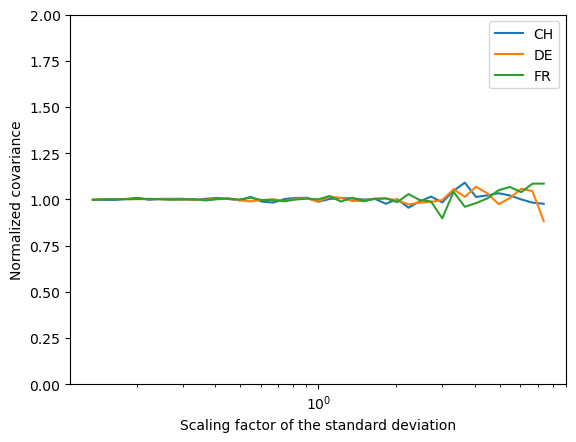

In [19]:
plt.plot(std_scaling_values, CH_cov_T_scaling / CH_cov_T, label='CH')
plt.plot(std_scaling_values, DE_cov_T_scaling / DE_cov_T, label='DE')
plt.plot(std_scaling_values, FR_cov_T_scaling / FR_cov_T, label='FR')
plt.xscale('log')
plt.ylim(0, 2)
plt.xlabel('Scaling factor of the standard deviation')
plt.ylabel('Normalized covariance')
plt.legend()
plt.show()

Since $T$ is a relatively large number, the covariance between series is actually pretty close to being constant:

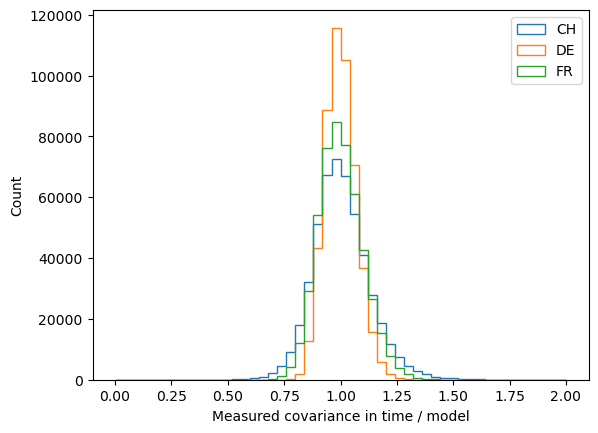

In [20]:
plt.hist(CH_cov_T_coefficients / CH_cov_T, histtype='step', label='CH', range=(0,2), bins=50)
plt.hist(DE_cov_T_coefficients / DE_cov_T, histtype='step', label='DE', range=(0,2), bins=50)
plt.hist(FR_cov_T_coefficients / FR_cov_T, histtype='step', label='FR', range=(0,2), bins=50)
plt.xlabel('Measured covariance in time / model')
plt.ylabel('Count')
plt.legend()
plt.show()

## Variance of a time series

The variance of an individual time series is defined as:
$$\text{var}_T(f^n) = \frac{1}{T} \sum_{t=1}^T (f_t^n - \bar{f}^n)^2
= \frac{1}{T} \sum_{t=1}^T (f_t^n)^2 - (\bar{f}^n)^2$$

When averaging over multiple series, this variance can be expressed as
$$\langle \text{var}_T(f) \rangle
= \frac{1}{T} \sum_{t=1}^T \langle f_t^2 \rangle - \frac{1}{T^2} \sum_{t=1}^T \sum_{t'=1}^T \langle f_t f_{t'} \rangle
= \frac{1}{T} \sum_{t=1}^T \Big[ \langle f_t\rangle^2 + \text{cov}_N(f_t, f_t) \Big]
    - \frac{1}{T^2} \sum_{t=1}^T \sum_{t'=1}^T \Big[ \langle f_t\rangle \langle f_{t'} \rangle + \text{cov}_N(f_t, f_{t'}) \Big]
$$

Using the definition of the average covariance $\langle \text{cov}_T(f) \rangle$, this is
$$
\langle \text{var}_T(f) \rangle = \langle \text{cov}_T(f) \rangle + \text{var}_T \left[ \text{cov}_N (f) \right]
$$
where
$$
\text{var}_T \left[ \text{cov}_N (f) \right] = \frac{1}{T} \sum_{t=1}^T \text{cov}_N(f_t, f_t)
    - \frac{1}{T^2} \sum_{t=1}^T \sum_{t'=1}^T \text{cov}_N(f_t, f_{t'})
$$

In [21]:
CH_varcov = ts.get_covariance_variance(CH_model)
DE_varcov = ts.get_covariance_variance(DE_model)
FR_varcov = ts.get_covariance_variance(FR_model)

In [22]:
CH_var_T = CH_cov_T + CH_varcov
DE_var_T = DE_cov_T + DE_varcov
FR_var_T = FR_cov_T + FR_varcov

In [23]:
CH_var_T_measured = CH_series.var(axis = 1)
DE_var_T_measured = DE_series.var(axis = 1)
FR_var_T_measured = FR_series.var(axis = 1)

In [24]:
CH_var_T_measured.mean() / CH_var_T, DE_var_T_measured.mean() / DE_var_T, FR_var_T_measured.mean() / FR_var_T

(0.9982090955867832, 1.0004257329037873, 0.9996440896561405)

In this case the variance depends on $\sigma$: if we scale $\sigma \to \lambda^2 \sigma$, then the variance obeys
$$\langle \text{var}_T(f) \rangle = \langle \text{cov}_T(f) \rangle + \lambda^2 \text{var}_T \left[ \text{cov}_N (f) \right]$$

In [25]:
CH_var_T_scaling = [ts.generate_time_series(CH_model, 100, std_scaling=std_scaling).var(axis = 1).mean()
                    for std_scaling in std_scaling_values]
DE_var_T_scaling = [ts.generate_time_series(DE_model, 100, std_scaling=std_scaling).var(axis = 1).mean()
                    for std_scaling in std_scaling_values]
FR_var_T_scaling = [ts.generate_time_series(FR_model, 100, std_scaling=std_scaling).var(axis = 1).mean()
                    for std_scaling in std_scaling_values]

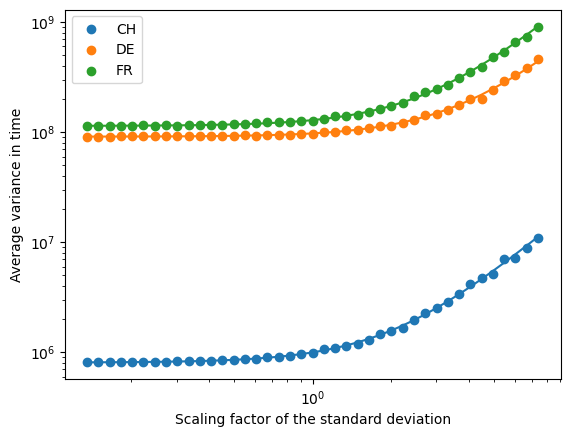

In [26]:
plt.plot(std_scaling_values, CH_cov_T + CH_varcov * std_scaling_values**2)
plt.plot(std_scaling_values, DE_cov_T + DE_varcov * std_scaling_values**2)
plt.plot(std_scaling_values, FR_cov_T + FR_varcov * std_scaling_values**2)
plt.scatter(std_scaling_values, CH_var_T_scaling, label='CH')
plt.scatter(std_scaling_values, DE_var_T_scaling, label='DE')
plt.scatter(std_scaling_values, FR_var_T_scaling, label='FR')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Scaling factor of the standard deviation')
plt.ylabel('Average variance in time')
plt.legend()
plt.show()

Like the covariance, the variance is more or less constant

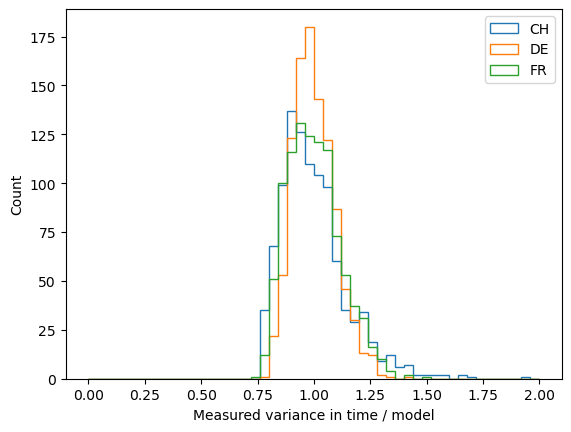

In [27]:
plt.hist(CH_var_T_measured / CH_var_T, histtype='step', label='CH', range=(0,2), bins=50)
plt.hist(DE_var_T_measured / DE_var_T, histtype='step', label='DE', range=(0,2), bins=50)
plt.hist(FR_var_T_measured / FR_var_T, histtype='step', label='FR', range=(0,2), bins=50)
plt.xlabel('Measured variance in time / model')
plt.ylabel('Count')
plt.legend()
plt.show()

## Correlation between time series

The correlation between two times series is defined by
$$\rho^{n,n'} = \frac{\text{cov}_T(f^n, f^{n'})}{\sqrt{\text{var}_T(f^n) \text{var}_T(f^{n'})}}$$

The distribution of correlations differs between countries. This is due to the fact that the variance of the input data is different: larger countries have more 'averaged' load profiles, the variance is smaller, and therefore the correlation between synthetic series is larger.

In [28]:
CH_correlations = ts.compute_pairwise_correlations(CH_series)
DE_correlations = ts.compute_pairwise_correlations(DE_series)
FR_correlations = ts.compute_pairwise_correlations(FR_series)

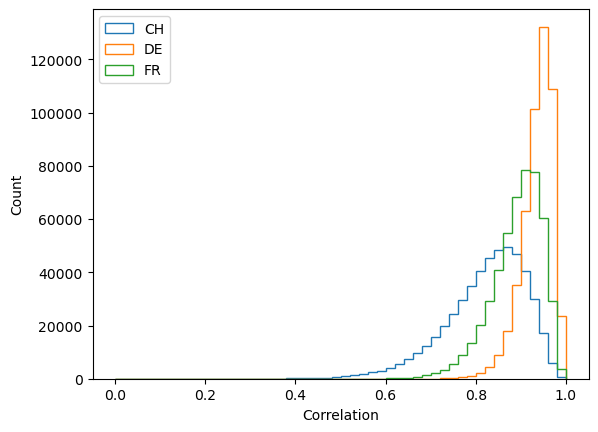

In [29]:
plt.hist(CH_correlations, range=(0,1), bins=50, histtype='step', label='CH')
plt.hist(DE_correlations, range=(0,1), bins=50, histtype='step', label='DE')
plt.hist(FR_correlations, range=(0,1), bins=50, histtype='step', label='FR')
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.show()

Since both the variance and the covariance of time series are pretty much constant, the average correlation between distinct series can be approximated as
$$
\langle \rho \rangle
= \frac{1}{N^2} \sum_{n = 1}^N \sum_{n' = 1}^N \frac{\text{cov}_T(f^n, f^{n'})}{\sqrt{\text{var}_T(f^n) \text{var}_T(f^{n'})}}
\approx \frac{\langle \text{cov}_T(f) \rangle}{\langle \text{var}_T(f) \rangle}
$$
From what we found above, this is
$$
\langle \rho \rangle
\approx \frac{\langle \text{cov}_T(f) \rangle}{\langle \text{cov}_T(f) \rangle + \text{var}_T \left[ \text{cov}_N (f) \right]}
= \frac{1}{1 + \kappa}
$$
where 
$$\kappa = \frac{\text{var}_T \left[ \text{cov}_N (f) \right]}{\langle \text{cov}_T(f) \rangle}$$

In [30]:
CH_k = CH_varcov / CH_cov_T
DE_k = DE_varcov / DE_cov_T
FR_k = FR_varcov / FR_cov_T
CH_k, DE_k, FR_k

(0.23649018231076488, 0.07033737232239311, 0.12888215277134663)

In [31]:
CH_correlations.mean() * (1 + CH_k), DE_correlations.mean() * (1 + DE_k), FR_correlations.mean() * (1 + FR_k)

(1.0149926712940034, 1.001725843473236, 1.005130987767911)

This give a simple rule on how correlations scale if we scale $\sigma \to \lambda^2 \sigma$:
$$\langle \rho \rangle = \frac{1}{1 + \lambda^2 \kappa}$$

In [32]:
CH_correlations_scaling = [ts.compute_pairwise_correlations(ts.generate_time_series(CH_model, 100, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]
DE_correlations_scaling = [ts.compute_pairwise_correlations(ts.generate_time_series(DE_model, 100, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]
FR_correlations_scaling = [ts.compute_pairwise_correlations(ts.generate_time_series(FR_model, 100, std_scaling=std_scaling)).mean()
                           for std_scaling in std_scaling_values]

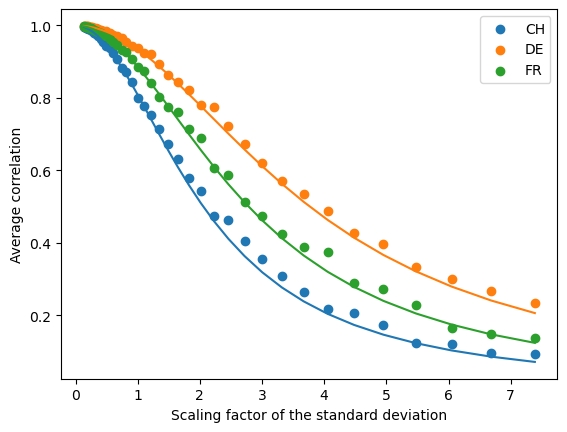

In [33]:
plt.plot(std_scaling_values, 1 / (1 + CH_k * std_scaling_values**2))
plt.plot(std_scaling_values, 1 / (1 + DE_k * std_scaling_values**2))
plt.plot(std_scaling_values, 1 / (1 + FR_k * std_scaling_values**2))
plt.scatter(std_scaling_values, CH_correlations_scaling, label='CH')
plt.scatter(std_scaling_values, DE_correlations_scaling, label='DE')
plt.scatter(std_scaling_values, FR_correlations_scaling, label='FR')
plt.xlabel('Scaling factor of the standard deviation')
plt.ylabel('Average correlation')
plt.legend()
plt.show()

This relation can be used to obtain time series with a given correlation by adjusting the standard deviation of the model
$$\lambda = \sqrt{\kappa^{-1} \left(\langle \rho \rangle^{-1} - 1 \right)}$$

In [34]:
CH_std_scaling = ts.get_optimal_std_scaling(CH_model, 0.8)
DE_std_scaling = ts.get_optimal_std_scaling(DE_model, 0.8)
FR_std_scaling = ts.get_optimal_std_scaling(FR_model, 0.8)
CH_std_scaling, DE_std_scaling, FR_std_scaling

(1.0281664925060878, 1.885284662635579, 1.3927514314741773)

In [35]:
CH_series_adjusted = ts.generate_time_series(CH_model, 1000, std_scaling=CH_std_scaling)
DE_series_adjusted = ts.generate_time_series(DE_model, 1000, std_scaling=DE_std_scaling)
FR_series_adjusted = ts.generate_time_series(FR_model, 1000, std_scaling=FR_std_scaling)

In [36]:
CH_correlations_adjusted = ts.compute_pairwise_correlations(CH_series_adjusted)
DE_correlations_adjusted = ts.compute_pairwise_correlations(DE_series_adjusted)
FR_correlations_adjusted = ts.compute_pairwise_correlations(FR_series_adjusted)

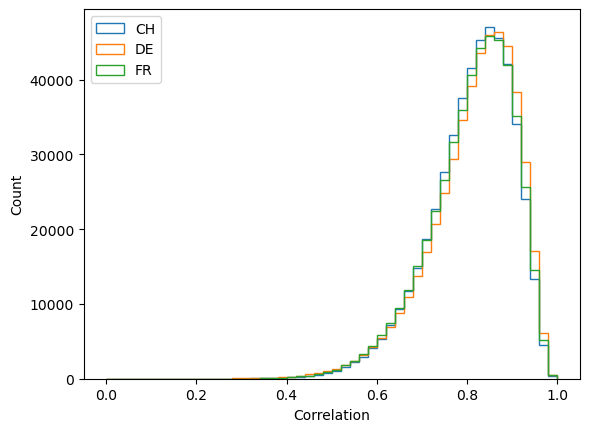

In [37]:
plt.hist(CH_correlations_adjusted, range=(0,1), bins=50, histtype='step', label='CH')
plt.hist(DE_correlations_adjusted, range=(0,1), bins=50, histtype='step', label='DE')
plt.hist(FR_correlations_adjusted, range=(0,1), bins=50, histtype='step', label='FR')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.legend()
plt.show()